In [14]:
import os
import zipfile
import requests

# Завантаження файлу
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
filename = "kagglecatsanddogs_5340.zip"

if not os.path.exists(filename):
    print("Завантаження датасету...")
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)
    print("Завантаження завершено!")

# Розпакування архіву
if not os.path.exists("cats_and_dogs_dataset"):
    print("Розпакування архіву...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("cats_and_dogs_dataset")
    print("Розпакування завершено!")
else:
    print("Датасет вже розпакований.")

Завантаження датасету...
Завантаження завершено!
Розпакування архіву...
Розпакування завершено!


In [15]:
import random
import shutil

# Шляхи до тек із зображеннями котів та собак
cats_source_dir = "cats_and_dogs_dataset/PetImages/Cat"
dogs_source_dir = "cats_and_dogs_dataset/PetImages/Dog"

# Шлях до кореневої теки для тренування та валідації
root_dir = "cats_and_dogs"

# Функція для створення тек для тренування та валідації
def create_train_val_dirs(root_path):
    # Шляхи до тек для тренування та валідації
    training_dir = os.path.join(root_path, "training")
    validation_dir = os.path.join(root_path, "validation")

    # Створюємо теки
    os.makedirs(training_dir)
    os.makedirs(validation_dir)

    # Створюємо теки для котів та собак у тренувальному та валідаційному наборах
    os.makedirs(os.path.join(training_dir, "cats"))
    os.makedirs(os.path.join(training_dir, "dogs"))
    os.makedirs(os.path.join(validation_dir, "cats"))
    os.makedirs(os.path.join(validation_dir, "dogs"))

# Функція для розподілу даних на тренувальний та валідаційний набори
def split_data(source_dir, training_dir, validation_dir, split_size):
    # Отримуємо список всіх зображень
    files = os.listdir(source_dir)
    # Випадковим чином перемішуємо список
    random.shuffle(files)
    # Визначаємо розмір тренувального набору
    train_size = int(len(files) * split_size)
    # Розподіляємо дані на тренувальний та валідаційний набори
    train_files = files[:train_size]
    val_files = files[train_size:]
    
    # Копіюємо файли у відповідні теки
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(training_dir, file))
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(validation_dir, file))

# Створюємо теки для тренування та валідації
create_train_val_dirs(root_dir)

# Розподіляємо дані на тренувальний та валідаційний набори
split_data(cats_source_dir, os.path.join(root_dir, "training", "cats"), os.path.join(root_dir, "validation", "cats"), split_size=0.9)
split_data(dogs_source_dir, os.path.join(root_dir, "training", "dogs"), os.path.join(root_dir, "validation", "dogs"), split_size=0.9)

print("Організація даних завершена.")

Організація даних завершена.


In [22]:
import os
from PIL import Image

def check_image(path):
    try:
        img = Image.open(path)  # Спробуємо відкрити зображення
        img.verify()  # Перевіримо коректність файлу зображення
        return True
    except Exception as e:
        print(f"Помилка при завантаженні або перевірці файлу {path}: {e}")
        return False

# Функція для фільтрації зображень у теках
def filter_images_in_directory(directory):
    files = os.listdir(directory)
    for file in files:
        path = os.path.join(directory, file)
        if not check_image(path):
            os.remove(path)  # Видаляємо пошкоджені зображення

# Фільтрація зображень у тренувальній та валідаційній теках
filter_images_in_directory(os.path.join(root_dir, "training", "cats"))
filter_images_in_directory(os.path.join(root_dir, "training", "dogs"))
filter_images_in_directory(os.path.join(root_dir, "validation", "cats"))
filter_images_in_directory(os.path.join(root_dir, "validation", "dogs"))
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),  # Додайте цей рядок
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Створюємо модель
model = create_model()

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Задаємо параметри генераторів даних
train_datagen = ImageDataGenerator(rescale=1.0/255.)
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Шляхи до тренувальної та валідаційної тек
train_dir = os.path.join(root_dir, "training")
val_dir = os.path.join(root_dir, "validation")

# Задаємо параметри генераторів
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size=20,
                                                class_mode='binary',
                                                target_size=(150, 150))

# Навчаємо модель
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=15,
                    verbose=1)

print("Навчання завершено.")

Found 22496 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.
Epoch 1/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 376s 331ms/step - accuracy: 0.6510 - loss: 0.6099 - val_accuracy: 0.7734 - val_loss: 0.4803
Epoch 2/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 302s 268ms/step - accuracy: 0.8000 - loss: 0.4308 - val_accuracy: 0.8050 - val_loss: 0.4251
Epoch 3/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 217s 192ms/step - accuracy: 0.8492 - loss: 0.3395 - val_accuracy: 0.8249 - val_loss: 0.4022
Epoch 4/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 195s 173ms/step - accuracy: 0.8971 - loss: 0.2476 - val_accuracy: 0.8133 - val_loss: 0.4740
Epoch 5/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 194s 172ms/step - accuracy: 0.9475 - loss: 0.1332 - val_accuracy: 0.8213 - val_loss: 0.5765
Epoch 6/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 198s 175ms/step - accuracy: 0.9789 - loss: 0.0615 - val_accuracy: 0.7930 - val_loss: 0.8828
Epoch 7/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 196s 174ms/step - accuracy: 0.9851 - loss: 0.0455 - val_accuracy: 0.8

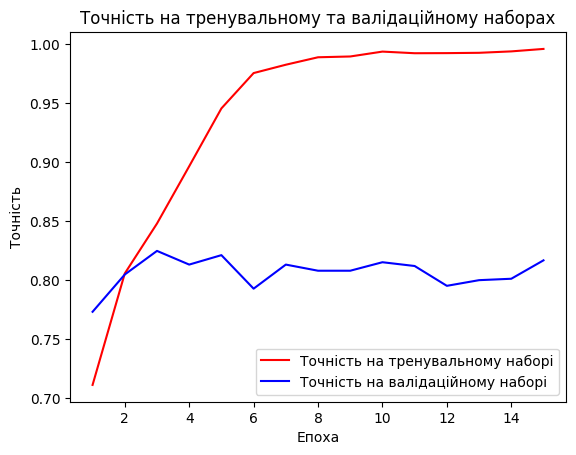

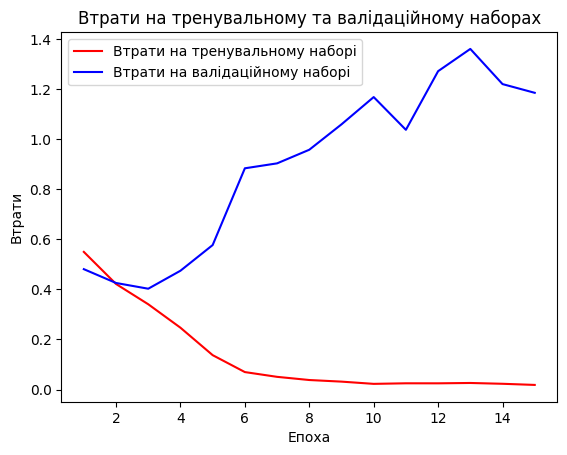

NameError: name 'files' is not defined

In [32]:
import matplotlib.pyplot as plt
import pickle

# Отримання кількості епох з історії тренування
epochs = range(1, len(history.history['accuracy']) + 1)

# Відображення графіку точності
plt.plot(epochs, history.history['accuracy'], 'r', label="Точність на тренувальному наборі")
plt.plot(epochs, history.history['val_accuracy'], 'b', label="Точність на валідаційному наборі")
plt.title('Точність на тренувальному та валідаційному наборах')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.show()

# Відображення графіку втрат
plt.plot(epochs, history.history['loss'], 'r', label="Втрати на тренувальному наборі")
plt.plot(epochs, history.history['val_loss'], 'b', label="Втрати на валідаційному наборі")
plt.title('Втрати на тренувальному та валідаційному наборах')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.show()

# Збереження історії в файл
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Завантаження історії з файлу
def download_history():
    files.download('history.pkl')

# Виклик функції для завантаження історії
download_history()